In [1]:
"""정규 방정식"""

import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3*X + np.random.rand(100,1)   # y = 4 + 3X + 가우시안잡음

X_b = np.c_[np.ones((100,1)), X]   # 모든 샘플에 x_0 = 1을 추가. c_은 1차원 배열을 칼럼으로 세로로 붙인다
# 선형대수 모듈(np.linalg)의 inv로 역행렬을, dot을 이용해 행렬 곱셈을 한다
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)   

print(theta_best)

# 유사역행렬을 이용해 theta 구하기. theta = X(역) * y
print(np.linalg.pinv(X_b).dot(y))

[[4.50190536]
 [2.97221005]]
[[4.50190536]
 [2.97221005]]


In [2]:
# 사이킷런 선형 회귀
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
print(lin_reg.intercept_, lin_reg.coef_)
print(lin_reg.predict(np.array([[0], [2]])))   # 예측값

[4.50190536] [[2.97221005]]
[[ 4.50190536]
 [10.44632545]]


In [3]:
"""경사 하강법"""

eta = 0.1   # 학습률
n_iterations = 1000
m = 100
theta = np.random.rand(2, 1)

for iteration in range(n_iterations):
    gradient = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta*gradient

theta

array([[4.50190536],
       [2.97221005]])

In [5]:
# 확률적 경사 하강법

n_epochs = 50
t0, t1 = 5, 50

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2, 1)

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index : random_index+1]
        yi = y[random_index : random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta*gradients
        
theta

array([[4.50555012],
       [2.98705593]])

In [6]:
# SGD: 경사 하강시 손실함수를 계산할 때 데이터의 일부만 사용해 훨씬 빨리 계산할 수 있음
from sklearn.linear_model import SGDRegressor

# 최대 1000번 경사 하강, 그러나 한 epoch에서 손실이 0.001보다 적게 되면 멈춤. 학습률 0.1
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())

print(sgd_reg.intercept_, sgd_reg.coef_)

[4.48404823] [2.97897837]


In [8]:
"""다항 회귀"""

m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

from sklearn.preprocessing import PolynomialFeatures

# 2차 다항회귀로 만들어 버리기
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
print(lin_reg.intercept_, lin_reg.coef_)

[1.99803697] [[0.8819492  0.52296081]]


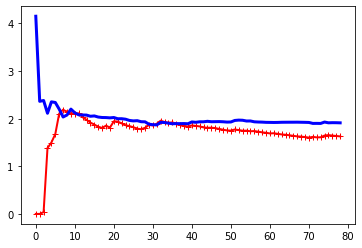

In [17]:
"""학습 곡선"""

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 훈련 세트: 모델링을 위한 세트 크기가 커질 수록 오차가 점점 커짐 
# 검증 세트: 모델링을 위한 세트 크기가 커질 수록 오차가 점점 줄어듦. 결국 두 곡선은 점점 가까워짐
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), 'r-+', linewidth=2, label='훈련 세트')
    plt.plot(np.sqrt(val_errors), 'b-', linewidth=3, label='검증 세트')

lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

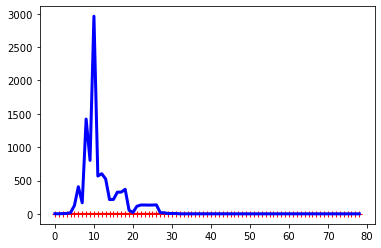

In [22]:
# 과적합 모델링의 대표적인 예
# 훈련 세트에서만 오차가 작고 검증 세트에서는 오차가 매우 큼을 알 수 있다

from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ('poly_features', PolynomialFeatures(degree=10, include_bias=False)),
        ('lin_reg', LinearRegression()),
])

plot_learning_curves(polynomial_regression, X, y)

In [26]:
"""규제 모델"""

from sklearn.linear_model import Ridge, Lasso, ElasticNet
ridge_reg = Ridge(alpha=1, solver='cholesky')
ridge_reg.fit(X, y)
print(ridge_reg.predict([[1.5]]))

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
print(lasso_reg.predict([[1.5]]))

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
print(elastic_net.predict([[1.5]]))

[[4.54242714]]
[4.48409362]
[4.49106934]


In [33]:
# 조기 종료: 검증 에러가 최솟값에 도달하면 바로 학습을 종료

from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

poly_scaler = Pipeline([
        ('poly_features', PolynomialFeatures(degree=90, include_bias=False)),
        ('std_scaler', StandardScaler())
])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True, penalty=None, 
                       learning_rate='constant', eta0=0.0005)
minimum_val_error = float('inf')
best_epoch = None
best_model = None

for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)   # warm=True니까 이전 모델 파라미터에서 훈련을 이어감
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

print(best_epoch)
print(minimum_val_error)

C:\Users\jaomi\anaconda3\envs\tens_2\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jaomi\anaconda3\envs\tens_2\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jaomi\anaconda3\envs\tens_2\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jaomi\anaconda3\envs\tens_2\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\Users\jaomi\anaconda3\envs\tens_2\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jaomi\anaconda3\envs\tens_2\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jaomi\anaconda3\envs\tens_2\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jaomi\anaconda3\envs\tens_2\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\Users\jaomi\anaconda3\envs\tens_2\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jaomi\anaconda3\envs\tens_2\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jaomi\anaconda3\envs\tens_2\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jaomi\anaconda3\envs\tens_2\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\Users\jaomi\anaconda3\envs\tens_2\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jaomi\anaconda3\envs\tens_2\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jaomi\anaconda3\envs\tens_2\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jaomi\anaconda3\envs\tens_2\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\Users\jaomi\anaconda3\envs\tens_2\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jaomi\anaconda3\envs\tens_2\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jaomi\anaconda3\envs\tens_2\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jaomi\anaconda3\envs\tens_2\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\Users\jaomi\anaconda3\envs\tens_2\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jaomi\anaconda3\envs\tens_2\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jaomi\anaconda3\envs\tens_2\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jaomi\anaconda3\envs\tens_2\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\Users\jaomi\anaconda3\envs\tens_2\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jaomi\anaconda3\envs\tens_2\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jaomi\anaconda3\envs\tens_2\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jaomi\anaconda3\envs\tens_2\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\Users\jaomi\anaconda3\envs\tens_2\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jaomi\anaconda3\envs\tens_2\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jaomi\anaconda3\envs\tens_2\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jaomi\anaconda3\envs\tens_2\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\Users\jaomi\anaconda3\envs\tens_2\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jaomi\anaconda3\envs\tens_2\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jaomi\anaconda3\envs\tens_2\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jaomi\anaconda3\envs\tens_2\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

0
20.6533912810186


C:\Users\jaomi\anaconda3\envs\tens_2\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jaomi\anaconda3\envs\tens_2\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jaomi\anaconda3\envs\tens_2\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jaomi\anaconda3\envs\tens_2\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

In [36]:
"""로지스틱 회귀: 소프트맥스 회귀(다항 로지스틱 회귀)"""

from sklearn.linear_model import LogisticRegression
from sklearn import datasets

iris = datasets.load_iris()
X = iris['data'][:, (2, 3)]   # 꽃잎의 길이, 너비
y = iris['target']

softmax_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=10)
softmax_reg.fit(X, y)
print(softmax_reg.predict([[5, 2]]))
print(softmax_reg.predict_proba([[5, 2]]))

[2]
[[6.38014896e-07 5.74929995e-02 9.42506362e-01]]
